In [205]:
import os
import numpy as np
from skimage import io, transform, feature, color, exposure
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [206]:
############# Load dataset ##############
def load_images(folder_path):
    images = []

    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(('.ppm')):
                img_path = os.path.join(root, filename)
                img = io.imread(img_path)
                img = transform.resize(img, (64, 64), anti_aliasing=True)
                images.append(img)
    
    return np.array(images)

# Load and preprocess images using HOG features
X_train = load_images('./dataset/training/')
X_test = load_images('./dataset/testing/')

# Shuffle the training and testing datasets
np.random.shuffle(X_train)
np.random.shuffle(X_test)

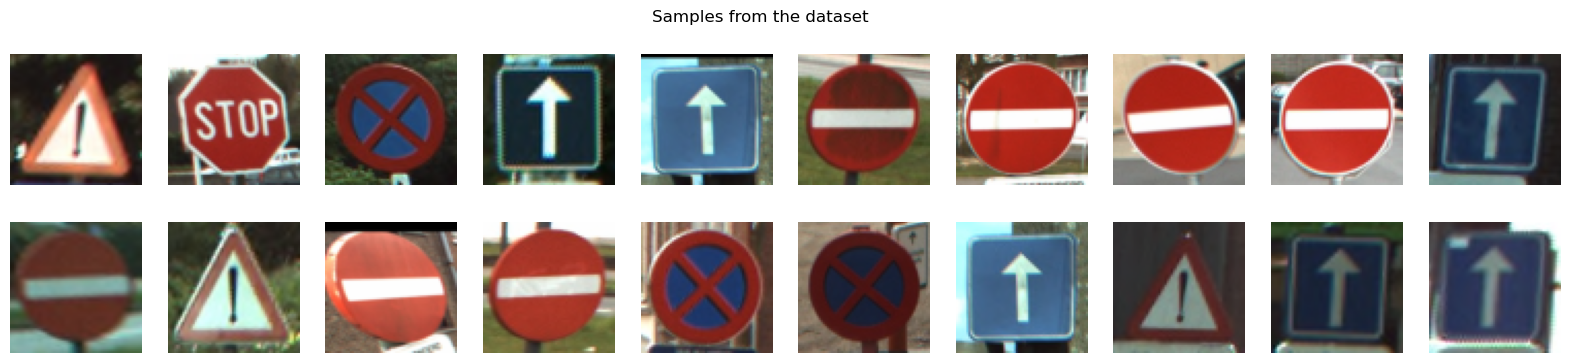

In [207]:
############# Show samples from X_train ##############
X_train_reshaped = X_train.reshape((-1, 64, 64, 3))

num_samples_to_display = 20

plt.figure(figsize=(20, 4))
for i in range(num_samples_to_display):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_train_reshaped[i])
    plt.axis('off')
plt.suptitle('Samples from the dataset')
plt.show()

In [208]:
############# Extract HOG features ##############
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Specify channel_axis for multichannel images
        hog_img = feature.hog(img, block_norm='L2-Hys', pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)
        hog_features.append(hog_img)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [209]:
############# MinMaxScaler #############
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)


In [210]:
############# PCA #############
n_components = 50

pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

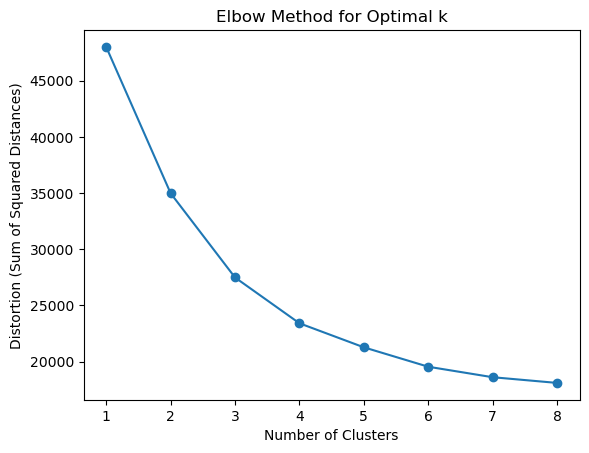

In [211]:
############# Elbow Method ##############
def find_optimal_clusters(data, max_clusters=8):
    distortions = []
    
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_init=10, n_clusters=i, init='random', random_state=42, max_iter=100)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion (Sum of Squared Distances)')
    plt.show()

find_optimal_clusters(X_train_pca)

In [212]:
############# Optimal num_clusters fn #############
def optimal_number_of_clusters():
    highest_score = 0
    opt_num_clusters = 0
    for num_clusters in range(2, 11):
        kmeans = KMeans(n_init=10, n_clusters=num_clusters, init='k-means++', random_state=42, max_iter=100)
        kmeans.fit(X_train_pca)
        sil_score = silhouette_score(X_train_pca, kmeans.labels_)
        if(sil_score > highest_score):
            highest_score = sil_score
            opt_num_clusters = num_clusters
        print(f'Number of Clusters: {num_clusters}, Silhouette Score: {round(sil_score, 2)}')
    print("================================================")
    print(f"Optimal number of clusters: {opt_num_clusters}")
    return opt_num_clusters

In [213]:
############ K-Means ##############
num_clusters = optimal_number_of_clusters()

kmeans = KMeans(n_init=10, n_clusters=num_clusters, init='k-means++', random_state=42, max_iter=100)
kmeans.fit(X_train_pca)

labels = kmeans.labels_

Number of Clusters: 2, Silhouette Score: 0.28
Number of Clusters: 3, Silhouette Score: 0.32
Number of Clusters: 4, Silhouette Score: 0.34
Number of Clusters: 5, Silhouette Score: 0.36
Number of Clusters: 6, Silhouette Score: 0.35
Number of Clusters: 7, Silhouette Score: 0.28
Number of Clusters: 8, Silhouette Score: 0.22
Number of Clusters: 9, Silhouette Score: 0.19
Number of Clusters: 10, Silhouette Score: 0.17
Optimal number of clusters: 5


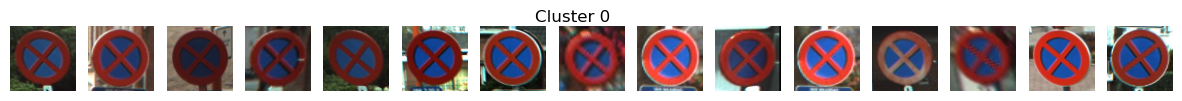

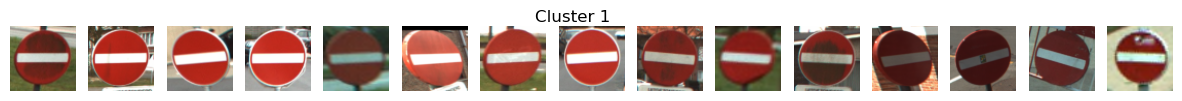

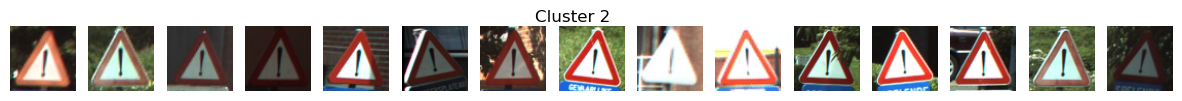

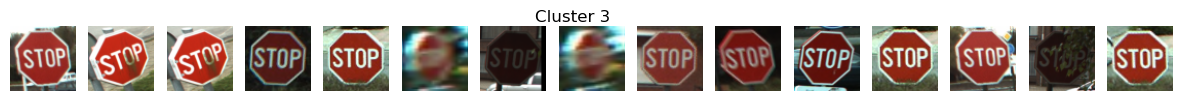

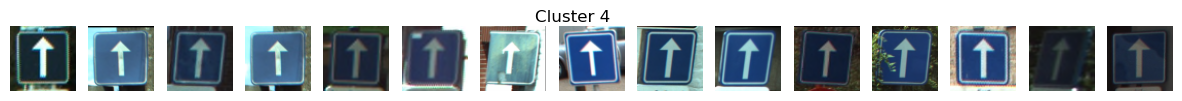

In [214]:
############# Display Samples from each cluster ##############
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    plt.figure(figsize=(15, 1))
    for j, index in enumerate(cluster_indices[:15]):
        plt.subplot(1, 15, j + 1)
        plt.imshow(X_train[index])
        plt.axis('off')
    plt.suptitle(f'Cluster {i}')
    plt.show()

In [215]:
############# Display number of images of each cluster ##############
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    numberOfImages = len(cluster_indices)
    print(f'Number of images of cluster {i} : {numberOfImages}')

Number of images of cluster 0 : 122
Number of images of cluster 1 : 348
Number of images of cluster 2 : 87
Number of images of cluster 3 : 43
Number of images of cluster 4 : 199


In [216]:
# ############## Display all images from each cluster ##############
# import math

# for i in range(num_clusters):
#     cluster_indices = np.where(labels == i)[0]
#     numberOfImages = len(cluster_indices)

#     numberOfCols = 10
#     numberOfRows = math.ceil(numberOfImages / numberOfCols)

#     plt.figure(figsize=(numberOfCols * 2, numberOfRows * 2))
#     for j, index in enumerate(cluster_indices[:numberOfImages]):
#         plt.subplot(numberOfRows, numberOfCols, j + 1)
#         plt.imshow(X_train[index])
#         plt.axis('off')
#     plt.suptitle(f'Cluster {i}')
#     plt.show()

In [217]:
############## Silhouette Score ##############
print("Train score :", round(kmeans.score(X_train_pca), 2))
print("Test score :", round(kmeans.score(X_test_pca), 2))
print("Centers :", len(kmeans.cluster_centers_))
print("Inertia :", round(kmeans.inertia_, 2))
print("=========================================")
sil_score = silhouette_score(X_train_pca, kmeans.labels_)
print("Silhouette Score :", round(sil_score, 2))

Train score : -21275.85
Test score : -3868.63
Centers : 5
Inertia : 21275.85
Silhouette Score : 0.36
